<a href="https://colab.research.google.com/github/NISHTHA0305/ML_Model/blob/main/solar_energy_prediction-using%20transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Weather Data 2014-11-30.xlsx to Weather Data 2014-11-30.xlsx
Epoch 1, Loss: 10.1104
Epoch 2, Loss: 3.9370
Epoch 3, Loss: 3.2248
Epoch 4, Loss: 2.8504
Epoch 5, Loss: 2.7041
Epoch 6, Loss: 2.6972
Epoch 7, Loss: 2.5989
Epoch 8, Loss: 2.4575
Epoch 9, Loss: 2.4660
Epoch 10, Loss: 2.3623
Epoch 11, Loss: 2.3471
Epoch 12, Loss: 2.3123
Epoch 13, Loss: 2.2976
Epoch 14, Loss: 2.2252
Epoch 15, Loss: 2.2264
Epoch 16, Loss: 2.2273
Epoch 17, Loss: 2.1862
Epoch 18, Loss: 2.1283
Epoch 19, Loss: 2.1157
Epoch 20, Loss: 2.1093
Epoch 21, Loss: 2.0686
Epoch 22, Loss: 2.0324
Epoch 23, Loss: 2.0409
Epoch 24, Loss: 2.0301
Epoch 25, Loss: 2.0448
Epoch 26, Loss: 2.0107
Epoch 27, Loss: 2.0190
Epoch 28, Loss: 2.0167
Epoch 29, Loss: 2.0113
Epoch 30, Loss: 2.0445
Epoch 31, Loss: 1.9693
Epoch 32, Loss: 1.9482
Epoch 33, Loss: 1.9798
Epoch 34, Loss: 1.9096
Epoch 35, Loss: 1.9721
Epoch 36, Loss: 1.9000
Epoch 37, Loss: 1.9167
Epoch 38, Loss: 1.8801
Epoch 39, Loss: 1.8736
Epoch 40, Loss: 1.9172
Test MSE: 19.8889
Te

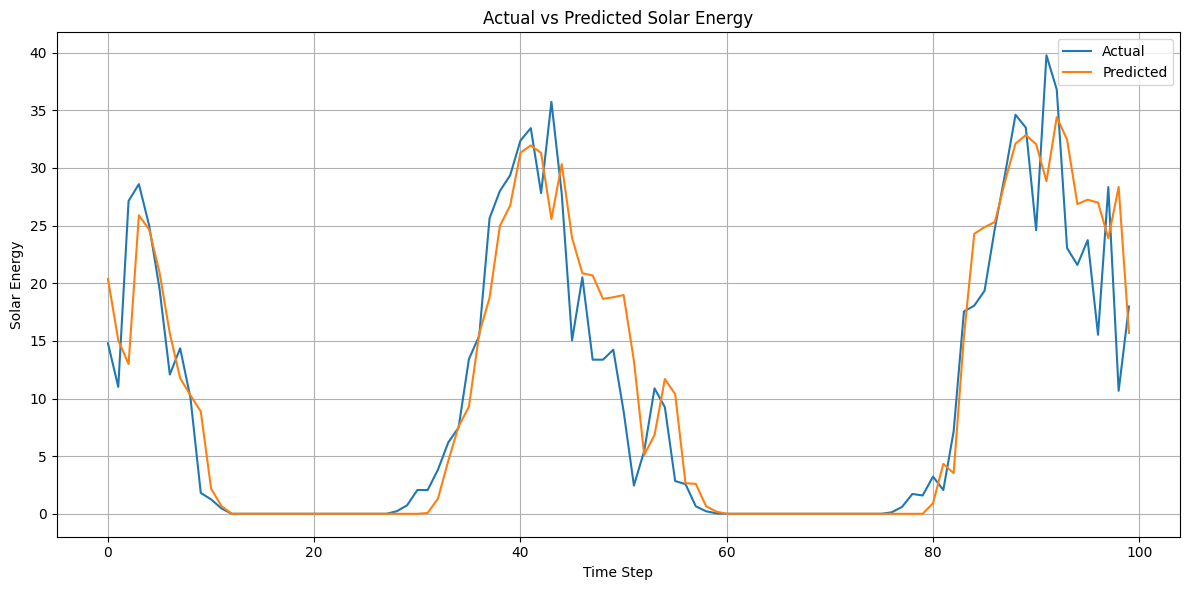

In [3]:
import torch
import torch.nn as nn
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Upload and load dataset
uploaded = files.upload()
df = pd.read_excel('Weather Data 2014-11-30.xlsx', sheet_name='Weather Data')

# Clean column names and preprocess
df.columns = df.columns.str.strip()
df = df.iloc[1:10000].copy()
df.replace('--', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(axis=1, thresh=int(0.8 * len(df)), inplace=True)
df.fillna(df.mean(), inplace=True)
df.dropna(inplace=True)

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

# Define target and features
target_col = 'SolarEnergy'
feature_cols = df.select_dtypes(include=np.number).columns.tolist()
if target_col in feature_cols:
    feature_cols.remove(target_col)
else:
    raise ValueError(f"Target column '{target_col}' not found in numeric columns.")

# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[[target_col]])

X_data = torch.tensor(X_scaled, dtype=torch.float32)
y_data = torch.tensor(y_scaled, dtype=torch.float32)

# Sequence windowing
input_window = 55
output_window = 5
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_sequences(X, y, input_window, output_window):
    xs, ys = [], []
    for i in range(len(X) - input_window - output_window):
        xs.append(X[i:i+input_window])
        ys.append(y[i+input_window:i+input_window+output_window].squeeze())
    return torch.stack(xs), torch.stack(ys)

X_seq, y_seq = create_sequences(X_data, y_data, input_window, output_window)

# Train-test split
train_X, test_X, train_y, test_y = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, feature_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.pos_encoder = PositionalEncoding(feature_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=4, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, output_window)
        self.src_mask = self._generate_square_subsequent_mask(input_window)

    def forward(self, src):
        src = self.pos_encoder(src)
        out = self.transformer_encoder(src, mask=self.src_mask.to(src.device))
        out = out[:, -1, :]  # take only the last time step
        return self.decoder(out)

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) == 1).float()
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# Initialize model
feature_size = X_seq.shape[2]
model = TransformerModel(feature_size=feature_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optional: learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_X = test_X.to(device)
    test_y = test_y.to(device)
    predictions = model(test_X)
    predictions = torch.clamp(predictions, min=0)  # No negative values

    # Convert to numpy
    predictions_np = predictions.cpu().numpy()
    actual_np = test_y.cpu().numpy()

    # Inverse scale only the first output for plotting
    predicted_unscaled = scaler_y.inverse_transform(predictions_np[:, [0]])
    actual_unscaled = scaler_y.inverse_transform(actual_np[:, [0]])

    # Evaluation metrics
    mse = np.mean((predicted_unscaled - actual_unscaled)**2)
    mae = np.mean(np.abs(predicted_unscaled - actual_unscaled))
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_unscaled[:100], label='Actual')
plt.plot(predicted_unscaled[:100], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy')
plt.title('Actual vs Predicted Solar Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
